In [30]:
import pandas as pd

# Load datasets
df_1718 = pd.read_csv('transfermarkt_fbref_201718.csv', sep=';', low_memory=False)
df_1819 = pd.read_csv('transfermarkt_fbref_201819.csv', sep=';', low_memory=False)
df_1920 = pd.read_csv('transfermarkt_fbref_201920.csv', sep=';', low_memory=False)

# Check the player name column name in each df and unify if needed
# For example, if one is 'player' and others 'player_name', rename accordingly:
# Assuming all use 'player' column, if not adjust here

# Rename 'value' columns to avoid conflicts after merging
df_1718 = df_1718.rename(columns={'value': 'value_original'})
df_1920 = df_1920.rename(columns={'value': 'value_future'})

# Select only player and value columns from 1718 and 1920 to merge later
df_1718_values = df_1718[['player', 'value_original']]
df_1920_values = df_1920[['player', 'value_future']]

# Merge 1718 and 1819 on 'player' with suffixes to distinguish overlapping columns
df_1718_1819 = pd.merge(df_1718, df_1819, on='player', how='outer', suffixes=('_1718', '_1819'))

# Merge the above result with 1920 on 'player'
df_all_years = pd.merge(df_1718_1819, df_1920, on='player', how='outer', suffixes=('', '_1920'))

# Now merge in the value_original and value_future to have those explicitly (optional)
# This helps if values in original dfs were overwritten or columns duplicated
df_all_years = df_all_years.drop(columns=['value_original', 'value_future'], errors='ignore')
df_all_years = df_all_years.merge(df_1718_values, on='player', how='left')
df_all_years = df_all_years.merge(df_1920_values, on='player', how='left')

print(df_all_years.shape)
print(df_all_years.columns)


(5034, 1198)
Index(['Unnamed: 0', 'player', 'nationality_1718', 'position_1718',
       'squad_1718', 'age_1718', 'birth_year_1718', 'height_1718',
       'position2_1718', 'foot_1718',
       ...
       'xGA', 'xGDiff', 'xGDiff/90', 'Attendance', 'CL', 'WinCL',
       'CLBestScorer', 'Season_1920', 'value_original', 'value_future'],
      dtype='object', length=1198)


In [34]:
import pandas as pd
import numpy as np  # add this at the top of your script
from sklearn.feature_selection import VarianceThreshold

# Assuming df_all_years is your merged dataframe

# Step 1: Drop columns with >50% missing or >90% zeros
threshold_missing = 0.5  # 50%
threshold_zero = 0.9     # 90%

# Drop columns with >50% missing
missing_frac = df_all_years.isna().mean()
cols_to_drop_missing = missing_frac[missing_frac > threshold_missing].index.tolist()

# Drop columns with >90% zeros (only numeric columns considered)
numeric_cols = df_all_years.select_dtypes(include='number').columns
zero_frac = (df_all_years[numeric_cols] == 0).mean()
cols_to_drop_zero = zero_frac[zero_frac > threshold_zero].index.tolist()

# Combine columns to drop
cols_to_drop = list(set(cols_to_drop_missing + cols_to_drop_zero))
df_clean = df_all_years.drop(columns=cols_to_drop)
print(f"Dropped {len(cols_to_drop)} columns due to missingness or zeros")
print(f"Data shape after dropping: {df_clean.shape}")

# Step 2: Drop categorical columns
categorical_cols = df_clean.select_dtypes(include=['object']).columns.tolist()
df_clean = df_clean.drop(columns=categorical_cols)
print(f"Dropped {len(categorical_cols)} categorical columns")
print(f"Data shape after dropping categoricals: {df_clean.shape}")

# Step 3: Drop low variance columns (variance <= 0.01)
selector = VarianceThreshold(threshold=0.01)
selector.fit(df_clean.fillna(0))  # Fill NA with 0 just for variance check
cols_after_variance = df_clean.columns[selector.get_support()]
df_clean = df_clean[cols_after_variance]
print(f"Shape after dropping low variance columns: {df_clean.shape}")

# Step 4: Drop highly correlated columns (correlation > 0.95)
corr_matrix = df_clean.corr().abs()
upper = corr_matrix.where(
    np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
)
to_drop_corr = [column for column in upper.columns if any(upper[column] > 0.95)]
df_clean = df_clean.drop(columns=to_drop_corr)
print(f"Dropped {len(to_drop_corr)} highly correlated columns")
print(f"Shape after dropping highly correlated columns: {df_clean.shape}")

# Step 5: Drop rows with missing values
df_clean = df_clean.dropna()
print(f"Shape after dropping rows with missing values: {df_clean.shape}")


Dropped 0 columns due to missingness or zeros
Data shape after dropping: (5034, 1198)
Dropped 25 categorical columns
Data shape after dropping categoricals: (5034, 1173)
Shape after dropping low variance columns: (5034, 739)
Dropped 245 highly correlated columns
Shape after dropping highly correlated columns: (5034, 494)
Shape after dropping rows with missing values: (1351, 494)


In [35]:
df_clean

,Unnamed: 0,age_1718,birth_year_1718,height_1718,games_1718,games_starts_1718,goals_1718,assists_1718,pens_made_1718,pens_att_1718,...,L,GF,GA,GDiff,xG,xGA,xGDiff,CL,value_original,value_future
1,574.0,27.0,1989.0,170.0,36.0,35.0,1.0,3.0,0.0,0.0,...,19.0,49.0,62.0,-13.0,46.2,61.1,-14.8,0.0,12000000.0,6000000.0
3,1408.0,30.0,1987.0,165.0,14.0,13.0,0.0,2.0,0.0,0.0,...,14.0,43.0,50.0,-7.0,43.9,48.3,-4.4,0.0,5000000.0,2000000.0
4,1408.0,30.0,1987.0,165.0,14.0,13.0,0.0,2.0,0.0,0.0,...,14.0,43.0,50.0,-7.0,43.9,48.3,-4.4,0.0,5000000.0,2000000.0
5,1409.0,30.0,1987.0,165.0,15.0,9.0,0.0,0.0,0.0,0.0,...,14.0,43.0,50.0,-7.0,43.9,48.3,-4.4,0.0,5000000.0,2000000.0
6,1409.0,30.0,1987.0,165.0,15.0,9.0,0.0,0.0,0.0,0.0,...,14.0,43.0,50.0,-7.0,43.9,48.3,-4.4,0.0,5000000.0,2000000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4809,2005.0,23.0,1994.0,192.0,30.0,18.0,4.0,2.0,0.0,0.0,...,4.0,81.0,37.0,44.0,70.9,36.4,34.5,1.0,10000000.0,24000000.0
4813,1863.0,27.0,1990.0,182.0,25.0,23.0,4.0,2.0,0.0,0.0,...,19.0,42.0,69.0,-27.0,41.4,48.1,-6.7,0.0,4500000.0,3000000.0
4814,302.0,20.0,1996.0,182.0,24.0,15.0,2.0,0.0,0.0,0.0,...,15.0,39.0,54.0,-15.0,41.2,54.5,-13.3,0.0,8000000.0,9000000.0
4815,1753.0,23.0,1994.0,190.0,1.0,1.0,0.0,0.0,0.0,0.0,...,4.0,81.0,37.0,44.0,70.9,36.4,34.5,1.0,3000000.0,2000000.0


In [36]:
# List all columns
columns = df_clean.columns.tolist()
print(columns)


['Unnamed: 0', 'age_1718', 'birth_year_1718', 'height_1718', 'games_1718', 'games_starts_1718', 'goals_1718', 'assists_1718', 'pens_made_1718', 'pens_att_1718', 'cards_yellow_1718', 'cards_red_1718', 'goals_per90_1718', 'assists_per90_1718', 'xg_1718', 'xa_1718', 'xg_per90_1718', 'xg_xa_per90_1718', 'shots_total_1718', 'shots_free_kicks_1718', 'shots_on_target_pct_1718', 'shots_total_per90_1718', 'shots_on_target_per90_1718', 'goals_per_shot_on_target_1718', 'xg_net_1718', 'passes_completed_1718', 'passes_pct_1718', 'passes_progressive_distance_1718', 'passes_completed_short_1718', 'passes_pct_short_1718', 'passes_pct_medium_1718', 'passes_completed_long_1718', 'passes_pct_long_1718', 'xa_net_1718', 'assisted_shots_1718', 'passes_into_final_third_1718', 'passes_into_penalty_area_1718', 'crosses_into_penalty_area_1718', 'progressive_passes_1718', 'passes_dead_1718', 'passes_free_kicks_1718', 'through_balls_1718', 'passes_pressure_1718', 'passes_switches_1718', 'crosses_1718', 'corner_ki

In [38]:
import pandas as pd

df = df_clean.copy()

cols_1718 = [col for col in df.columns if col.endswith('_1718')]
cols_1819 = [col for col in df.columns if col.endswith('_1819')]

base_names_1718 = [col[:-5] for col in cols_1718]
base_names_1819 = [col[:-5] for col in cols_1819]

common_bases = set(base_names_1718).intersection(set(base_names_1819))

# Create a new DataFrame for the combined columns
combined_cols = pd.DataFrame(index=df.index)

for base in common_bases:
    col_1718 = base + '_1718'
    col_1819 = base + '_1819'
    combined_cols[base] = df[[col_1718, col_1819]].sum(axis=1)

# Drop the old columns from df
df.drop(columns=list(common_bases) + [col + '_1718' for col in common_bases] + [col + '_1819' for col in common_bases], errors='ignore', inplace=True)

# Concatenate combined columns to the dataframe
df = pd.concat([df, combined_cols], axis=1)

print("New dataframe shape after aggregation:", df.shape)


New dataframe shape after aggregation: (1351, 187)


C:\Users\ASUS\AppData\Local\Temp\ipykernel_14968\2352648535.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  combined_cols[base] = df[[col_1718, col_1819]].sum(axis=1)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_14968\2352648535.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  combined_cols[base] = df[[col_1718, col_1819]].sum(axis=1)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_14968\2352648535.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which

In [39]:
# List all columns
columns = df.columns.tolist()
print(columns)


['Unnamed: 0', 'age_1718', 'birth_year_1718', 'height_1718', 'pens_att_1718', 'assists_per90_1718', 'touches_1718', 'touches_mid_3rd_1718', 'sca_per90m_1718', 'minutes_gkm_1718', 'value', 'goals_assists_per90_1819', 'gca_passes_live_1819', 'gca_og_for_1819', 'passes_pct_launched_gk_1819', 'assists_per90', 'goals_assists_per90', 'npxg_per90', 'gca_passes_live', 'gca_og_for', 'clean_sheets', 'crosses_stopped_gk', 'shots_totalm', 'shots_total_per90m', 'shots_on_target_per90m', 'sca_per90m', 'clearancesm', 'passes_receivedm', 'minutes_gkm', 'pct_goal_kicks_launchedm', 'value_original', 'value_future', 'passes_pctm', 'xg_xa_per90', 'passes_dead', 'pens_won', 'pass_targetsm', 'offsides', 'passes_completed', 'aerials_won', 'corner_kicks_straight', 'goals_against_per90_gk', 'xG', 'GA', 'passes_pct_longm', 'passes_completedm', 'passes_pressure', 'carry_progressive_distancem', 'W', 'passes_head', 'tackles_mid_3rd', 'pens_saved', 'carriesm', 'cards_yellow', 'passes_pct_short', 'GDiff', 'passes_in

In [46]:
df.head()

,Unnamed: 0,age_1718,birth_year_1718,height_1718,pens_att_1718,assists_per90_1718,touches_1718,touches_mid_3rd_1718,sca_per90m_1718,minutes_gkm_1718,...,passes_received_pct,blocks,pressures_def_3rd,pressure_regain_pct,dribble_tackles_pctm,passes_blocked,xGA,gca_shots,xg,draws_gk
1,574.0,27.0,1989.0,170.0,0.0,0.09,1983.0,897.0,0.001433,0.0,...,183.8,93.0,347.0,61.9,0.029868,88.0,118.8,0.0,1.3,0.0
3,1408.0,30.0,1987.0,165.0,0.0,0.16,414.0,148.0,0.000888,0.0,...,157.9,54.0,178.0,45.6,0.056180,43.0,111.3,1.0,1.0,0.0
4,1408.0,30.0,1987.0,165.0,0.0,0.16,414.0,148.0,0.000888,0.0,...,157.9,54.0,178.0,45.6,0.056180,43.0,111.3,1.0,1.0,0.0
5,1409.0,30.0,1987.0,165.0,0.0,0.00,314.0,136.0,0.000198,0.0,...,147.6,47.0,137.0,43.0,0.061694,37.0,113.4,1.0,0.7,0.0
6,1409.0,30.0,1987.0,165.0,0.0,0.00,314.0,136.0,0.000198,0.0,...,147.6,47.0,137.0,43.0,0.061694,37.0,113.4,1.0,0.7,0.0


In [47]:
if 'Unnamed: 0' in df.columns:
    df_all_years = df.drop(columns=['Unnamed: 0'])


In [48]:
df_all_years

,age_1718,birth_year_1718,height_1718,pens_att_1718,assists_per90_1718,touches_1718,touches_mid_3rd_1718,sca_per90m_1718,minutes_gkm_1718,value,...,passes_received_pct,blocks,pressures_def_3rd,pressure_regain_pct,dribble_tackles_pctm,passes_blocked,xGA,gca_shots,xg,draws_gk
1,27.0,1989.0,170.0,0.0,0.09,1983.0,897.0,0.001433,0.0,10000000.0,...,183.8,93.0,347.0,61.9,0.029868,88.0,118.8,0.0,1.3,0.0
3,30.0,1987.0,165.0,0.0,0.16,414.0,148.0,0.000888,0.0,5000000.0,...,157.9,54.0,178.0,45.6,0.056180,43.0,111.3,1.0,1.0,0.0
4,30.0,1987.0,165.0,0.0,0.16,414.0,148.0,0.000888,0.0,5000000.0,...,157.9,54.0,178.0,45.6,0.056180,43.0,111.3,1.0,1.0,0.0
5,30.0,1987.0,165.0,0.0,0.00,314.0,136.0,0.000198,0.0,5000000.0,...,147.6,47.0,137.0,43.0,0.061694,37.0,113.4,1.0,0.7,0.0
6,30.0,1987.0,165.0,0.0,0.00,314.0,136.0,0.000198,0.0,5000000.0,...,147.6,47.0,137.0,43.0,0.061694,37.0,113.4,1.0,0.7,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4809,23.0,1994.0,192.0,0.0,0.11,855.0,435.0,0.000163,0.0,35000000.0,...,118.0,65.0,73.0,55.9,0.035071,74.0,80.7,2.0,18.8,0.0
4813,27.0,1990.0,182.0,0.0,0.09,836.0,419.0,0.022222,0.0,5000000.0,...,145.6,30.0,66.0,53.3,0.009287,46.0,121.9,0.0,8.5,0.0
4814,20.0,1996.0,182.0,0.0,0.00,1260.0,720.0,0.004728,0.0,15000000.0,...,178.0,59.0,377.0,49.9,0.021308,39.0,113.2,1.0,4.0,0.0
4815,23.0,1994.0,190.0,0.0,0.00,40.0,2.0,0.000783,0.0,3000000.0,...,200.0,0.0,0.0,0.0,0.021410,0.0,80.7,0.0,0.0,0.0


In [49]:
# Define threshold, e.g., drop columns with more than 90% zeros
zero_threshold = 0.9

# Calculate the proportion of zeros per column
zero_fraction = (df_all_years == 0).mean()

# Select columns to drop
cols_to_drop_zeros = zero_fraction[zero_fraction > zero_threshold].index.tolist()

# Drop 'Unnamed: 0' and these zero-heavy columns
df_all_years = df_all_years.drop(columns=['Unnamed: 0'] + cols_to_drop_zeros, errors='ignore')

print(f"Dropped {len(cols_to_drop_zeros)} columns due to high zero values")


Dropped 24 columns due to high zero values


In [55]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import r2_score

# Features (all columns except target columns)
X = df_final.drop(columns=['value_original', 'value_future'])

# Target variable
y = df_final['value_future']

# Split dataset into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize SGDRegressor for linear regression via gradient descent
model_gd = SGDRegressor(
    loss='squared_error',
    penalty=None,
    max_iter=1000,
    tol=1e-3,
    learning_rate='invscaling',
    eta0=0.01,
    random_state=42
)

# Train the model
model_gd.fit(X_train, y_train)

# Predict on test set
y_pred_gd = model_gd.predict(X_test)

# Evaluate model performance
print(f"R² score with SGDRegressor (gradient descent): {r2_score(y_test, y_pred_gd):.4f}")


R² score with SGDRegressor (gradient descent): -164.9227


In [58]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Assume df_final is your scaled DataFrame

# Define features (X) and target (y)
# Here, 'value_future' is the target, 'value_original' should not be a feature (usually)
X = df_final.drop(columns=['value_future', 'value_original'])  # drop target and original value from features
y = df_final['value_future']

# Split into train and test (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Initialize Linear Regression model
model = LinearRegression()

# Train the model
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate model performance with R² score
r2 = r2_score(y_test, y_pred)
print(f"R² score with Linear Regression: {r2:.4f}")


R² score with Linear Regression: 0.8991


In [59]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score

# Assuming df_final is your DataFrame and target columns:
X = df_final.drop(columns=['value_future', 'value_original'])  # Features
y = df_final['value_future']  # Target

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Pipeline for scaling + SGDRegressor
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('sgd', SGDRegressor(random_state=42, max_iter=1000, tol=1e-3))
])

# Define hyperparameters grid to search
param_grid = {
    'sgd__alpha': [0.0001, 0.001, 0.01, 0.1],           # Regularization strength
    'sgd__learning_rate': ['constant', 'optimal', 'invscaling', 'adaptive'],
    'sgd__eta0': [0.01, 0.1, 0.5],                      # Initial learning rate (used in some schedules)
    'sgd__penalty': ['l2', 'l1', 'elasticnet'],         # Regularization type
    'sgd__max_iter': [1000, 2000],                       # Max iterations
}

# Setup GridSearchCV
grid_search = GridSearchCV(pipe, param_grid, cv=5, scoring='r2', verbose=2, n_jobs=-1)

# Fit model with grid search
grid_search.fit(X_train, y_train)

# Best params and best score
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation R² score:", grid_search.best_score_)

# Evaluate on test set
y_pred = grid_search.predict(X_test)
test_r2 = r2_score(y_test, y_pred)
print("Test set R² score:", test_r2)


Fitting 5 folds for each of 288 candidates, totalling 1440 fits
Best parameters: {'sgd__alpha': 0.1, 'sgd__eta0': 0.1, 'sgd__learning_rate': 'adaptive', 'sgd__max_iter': 1000, 'sgd__penalty': 'elasticnet'}
Best cross-validation R² score: 0.8870846254605329
Test set R² score: 0.896117949751486


In [143]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score

# Assume df_final is your scaled dataframe with 'value_original' and 'value_future'

# Define features and target
X = df_final.drop(columns=['value_future', 'value_original'])
y = df_final['value_future']

# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Scale features
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

# Scale target
scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).ravel()
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)).ravel()

# Create SGDRegressor
sgd = SGDRegressor(random_state=42)

# Hyperparameter grid to tune
param_grid = {
    'alpha': [0.01, 0.1, 1],
    'eta0': [0.001, 0.01, 0.1],
    'learning_rate': ['constant', 'adaptive'],
    'max_iter': [1000, 2000],
    'penalty': ['elasticnet', 'l2', 'l1']
}

# Use GridSearchCV to find best parameters (3-fold for speed)
grid_search = GridSearchCV(
    sgd,
    param_grid,
    cv=3,
    scoring='r2',
    n_jobs=-1,
    verbose=1
)

# Fit GridSearch on scaled data
grid_search.fit(X_train_scaled, y_train_scaled)



print("Best parameters:", grid_search.best_params_)
print("Best CV R²:", grid_search.best_score_)

# Predict on test set using best estimator
y_pred_scaled = grid_search.best_estimator_.predict(X_test_scaled)

# Inverse scale predictions to original scale
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()

# Calculate R² score on original scale target and predictions
r2_test = r2_score(y_test, y_pred)
print(f"Test set R² score: {r2_test:.4f}")


import joblib

# After training your grid_search model and scalers
joblib.dump(grid_search.best_estimator_, 'model.pkl')
joblib.dump(scaler_X, 'scaler_X.pkl')
joblib.dump(scaler_y, 'scaler_y.pkl')


Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best parameters: {'alpha': 0.01, 'eta0': 0.001, 'learning_rate': 'adaptive', 'max_iter': 1000, 'penalty': 'l1'}
Best CV R²: 0.9149059912503468
Test set R² score: 0.9139


['scaler_y.pkl']

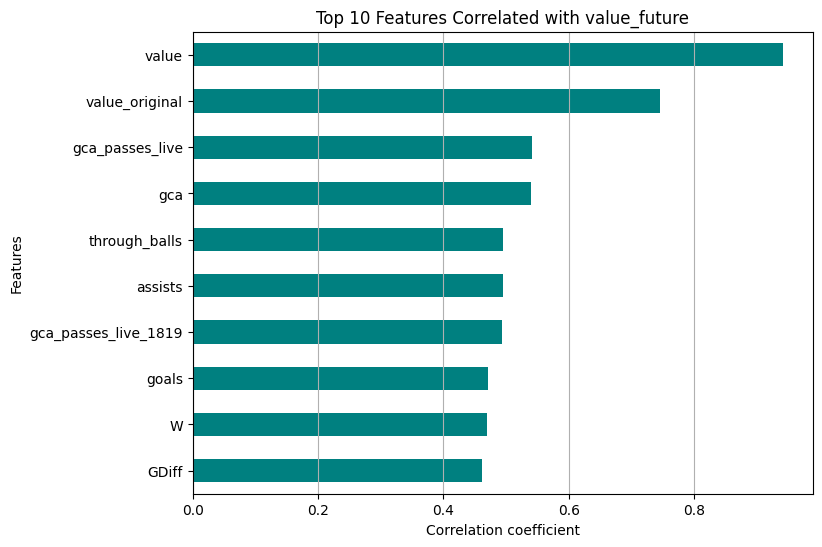

In [80]:
import matplotlib.pyplot as plt

# Compute correlation of all features with 'value_future' and drop itself
corr_with_target = df_final.corr()['value_future'].drop('value_future')

# Take absolute values and get top 10 features by absolute correlation
top_n = 10
top_features = corr_with_target.abs().sort_values(ascending=False).head(top_n).index

# Filter original correlations for these top features (preserve sign)
top_corr = corr_with_target.loc[top_features].sort_values()

# Plot
plt.figure(figsize=(8, 6))
top_corr.plot(kind='barh', color='teal')
plt.title(f'Top {top_n} Features Correlated with value_future')
plt.xlabel('Correlation coefficient')
plt.ylabel('Features')
plt.grid(axis='x')
plt.show()


In [87]:
import plotly.express as px
import plotly.io as pio

# Set renderer for Jupyter Notebook
pio.renderers.default = "notebook_connected"

# Plot Actual vs Predicted values
fig = px.scatter(
    x=y_test,
    y=y_pred,
    labels={'x': 'Actual Future Value', 'y': 'Predicted Future Value'},
    title='Actual vs Predicted Player Values'
)

# Add diagonal line for perfect prediction reference
fig.add_shape(
    type='line',
    x0=y_test.min(), y0=y_test.min(),
    x1=y_test.max(), y1=y_test.max(),
    line=dict(color='red', dash='dash')
)

fig.show()


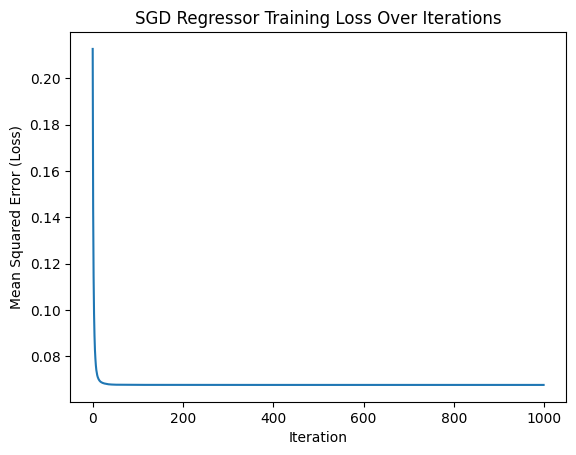

In [91]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error

# Use best parameters from your GridSearchCV here
best_params = {
    'alpha': 0.01,
    'eta0': 0.001,
    'learning_rate': 'constant',
    'max_iter': 1000,
    'penalty': 'elasticnet',
    'random_state': 42,
    'tol': 1e-6,
    'warm_start': True  # To continue training over multiple .fit calls
}

sgd = SGDRegressor(**best_params)

loss_history = []

# Train for max_iter iterations, recording loss per iteration
for epoch in range(best_params['max_iter']):
    sgd.partial_fit(X_train_scaled, y_train_scaled)
    y_pred_train = sgd.predict(X_train_scaled)
    mse = mean_squared_error(y_train_scaled, y_pred_train)
    loss_history.append(mse)

plt.plot(loss_history)
plt.xlabel('Iteration')
plt.ylabel('Mean Squared Error (Loss)')
plt.title('SGD Regressor Training Loss Over Iterations')
plt.show()


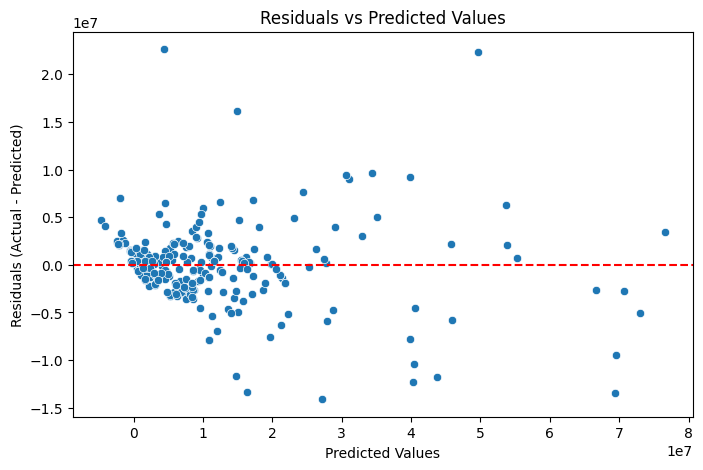

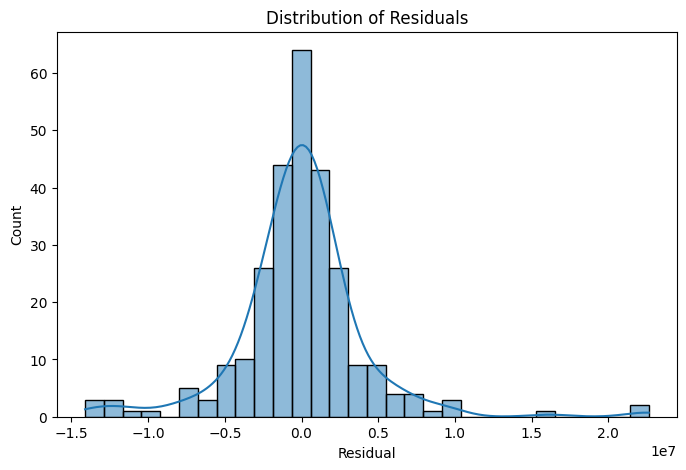

In [93]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate residuals: actual - predicted
residuals = y_test - y_pred

# Residuals vs Predicted values scatter plot
plt.figure(figsize=(8,5))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, color='red', linestyle='--')  # zero error line
plt.xlabel('Predicted Values')
plt.ylabel('Residuals (Actual - Predicted)')
plt.title('Residuals vs Predicted Values')
plt.show()

# Optional: Histogram of residuals to check distribution
plt.figure(figsize=(8,5))
sns.histplot(residuals, bins=30, kde=True)
plt.xlabel('Residual')
plt.title('Distribution of Residuals')
plt.show()


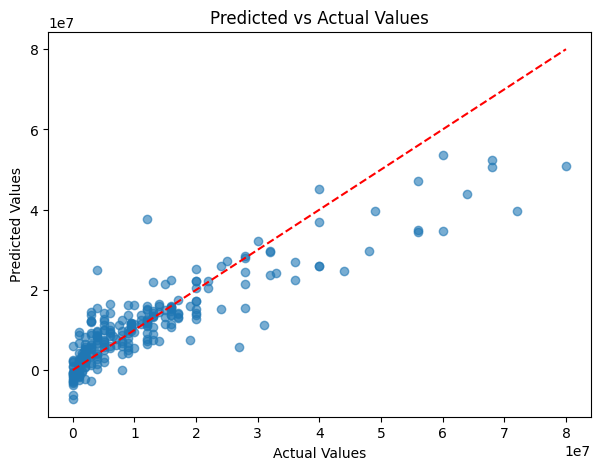

In [96]:
plt.figure(figsize=(7,5))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Predicted vs Actual Values")
plt.show()


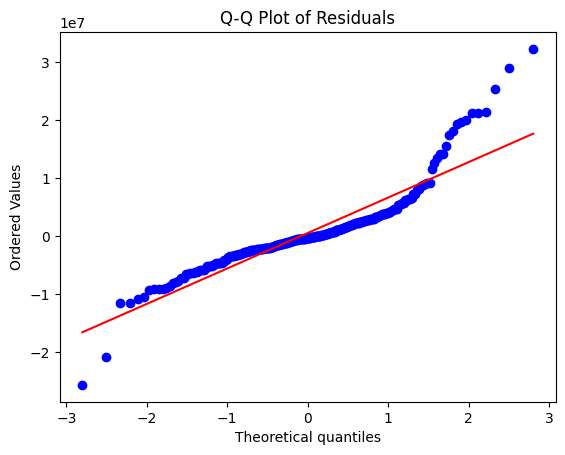

In [97]:
import scipy.stats as stats
import matplotlib.pyplot as plt

stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Q-Q Plot of Residuals")
plt.show()


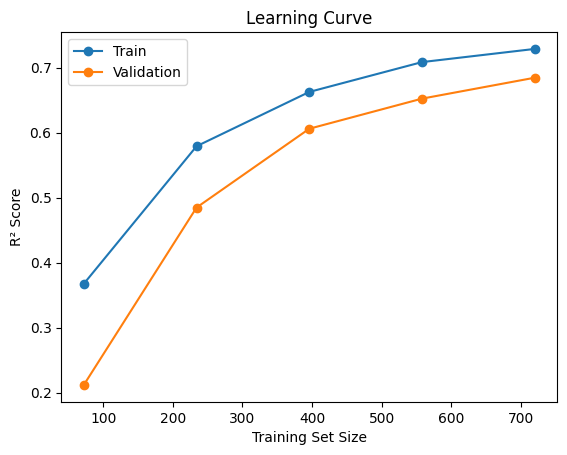

In [98]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, val_scores = learning_curve(
    grid_search.best_estimator_, X_train, y_train, cv=3, scoring='r2'
)

plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', label="Train")
plt.plot(train_sizes, np.mean(val_scores, axis=1), 'o-', label="Validation")
plt.xlabel("Training Set Size")
plt.ylabel("R² Score")
plt.title("Learning Curve")
plt.legend()
plt.show()
